In [1]:
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import random

# Problem 5

In [2]:
# load data
data = loadmat('./data/IP2classes.mat')

datax = data['X']
datay = data['Y']

In [3]:
def get_orth_mat(X, method='qr'):
    if method == 'qr':
        u, r = np.linalg.qr(X)
    elif method == 'svd':
        u, s, vh = np.linalg.svd(X)
    elif method == 'closest_orth':
        raise ValueError('Method closest_orth is not implemented yet!')
    else:
        raise ValueError('Method %s is not valid!')
    return u
        
def flag(data_collection):
    u_collection = None
    for data in data_collection:
        u = get_orth_mat(data, method='qr')
        if u_collection is None:
            u_collection = u
        else:
            u_collection = np.hstack((u_collection, u))
    averages, s, vh = np.linalg.svd(u_collection)
    
    return averages

In [4]:
def Gr(X, k, num_points=25):
    p = X.shape[1]
    inds = random.sample(range(p), num_points*k)
    return np.array([X[:, inds[i*k:(i+1)*k]] for i in range(num_points)])

In [5]:
def chordal_dist_matrix(data_collection):
    u_collection = []
    for data in data_collection:
        u = get_orth_mat(np.array(data), method='qr')
        u_collection.append(u)
    n = len(u_collection)
    dist_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(i+1, n):
            _, s, _ = np.linalg.svd(u_collection[i].T @ u_collection[j])
            dist_matrix[i, j] = np.sqrt(np.sum(1 - s**2))
            dist_matrix[j, i] = dist_matrix[i, j]
    return dist_matrix

def MDS(D):
    '''
    This function computes MDS with a distance matrix
    :param D: input distance matrix
    :return: V_tilde, whose rows are result configurations, and the eigenvalues
    '''
    P = D.shape[0]  # D is a symmetric distrance matrix
    A = -0.5 * D**2
    H = np.eye(P) - np.ones((P, P))/P
    B = H@A@H
    w, V = np.linalg.eig(B)
    V = V[:, np.flip(np.argsort(w), axis=0)]
    w = w[np.flip(np.argsort(w), axis=0)]
    V = V[:, w>0]
    w = w[w>0]
    V_tilde = V * np.sqrt(w[None, :])

    return V_tilde, w

def plot_mds(res):
    # labels = ['X']*25 + ['Y']*25
    plt.plot(res[:25, 0], res[:25, 1], 'r.', label='X')
    plt.plot(res[25:50, 0], res[25:50, 1], 'b.', label='Y')
    plt.plot(res[51, 0], res[51, 1], 'b*', markersize=10, label='Y_mean')
    plt.plot(res[50, 0], res[50, 1], 'r*', markersize=10, label='X_mean')
    # for i in range(res.shape[0]):
    #     plt.text(res[i, 0]+1, res[i, 1]+1, labels[i])
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
    plt.show()

In [6]:
def main(k, datax, datay):
    # get 25 points for each dataset in grassmannian
    x_set = Gr(datax, k)
    y_set = Gr(datay, k)
    
    # find flag for each set
    x_mean = flag(x_set)
    y_mean = flag(y_set)
    
    # Take the first eigenvector as the mean
    x_mean_reshape = x_mean[:, :k].reshape((1, x_mean.shape[0], k))
    y_mean_reshape = y_mean[:, :k].reshape((1, y_mean.shape[0], k))
#     print(x_mean_reshape.shape, y_mean_reshape.shape)
    
    # MDS analysis, mapping to euclidean distance
#     dist_matrix = chordal(np.vstack((x_set, y_set, x_mean_reshape, y_mean_reshape)))
    collection = x_set.tolist() + y_set.tolist() + x_mean_reshape.tolist() + y_mean_reshape.tolist()
#     print(collection[50])
    dist_matrix = chordal_dist_matrix(collection)
    res, _ = MDS(dist_matrix)
#     print(res[50, :2])
#     print(res[51, :2])
    # plot result
    plot_mds(res)
#     return res

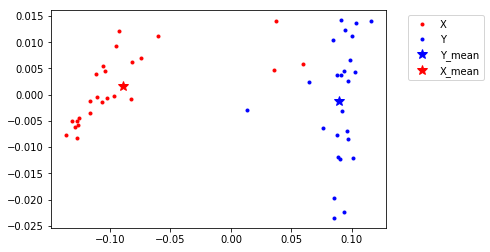

In [7]:
main(1, datax, datay)

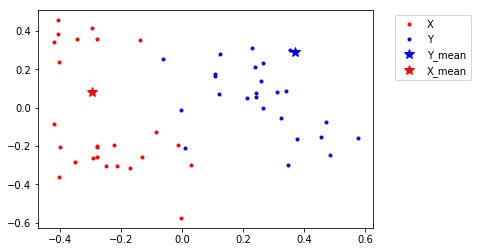

In [16]:
main(5, datax, datay)

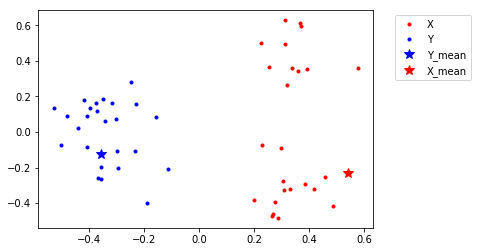

In [12]:
main(10, datax, datay)